<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/01_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

# Read Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


In [8]:
data_tracks_lyrics = pd.read_csv("music/data_tracks_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_tracks_tags_lyrics = pd.read_csv("music/data_tracks_tags_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna().drop_duplicates('track_id')
data_bio = pd.read_csv("music/data_artists_biography.txt", sep=",").drop(['Unnamed: 0'],axis=1).dropna()
data_all_info = pd.read_csv('music/data_all_info.txt', sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_interaction = pd.read_csv("music/data_user_track_interaction_with_ones.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

data_tracks_tags_lyrics = data_all_info.merge(data_bio)
data_interaction = data_interaction.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), on = 'track_id', how = 'inner').drop_duplicates()
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction[['track_id']], on = 'track_id', how = 'inner').drop_duplicates()

data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

In [9]:
data_interaction_all = data_interaction.copy()

In [10]:
# filter out playcount 1
data_interaction = data_interaction[data_interaction['count'] != 1]
len(data_interaction)

465329

In [11]:
data_interaction_plot = data_interaction.copy()

In [12]:
# filter out tracks with too little playcount
df_per_track = data_interaction.groupby(['track_id']).size().reset_index(name='counts')
tracks = df_per_track[df_per_track['counts'] >= 25]['track_id'].values
data_interaction = data_interaction[data_interaction['track_id'].isin(tracks)]

In [13]:
# filter out users with too little playcount
df_per_users = data_interaction.groupby(['user_id']).size().reset_index(name='counts')
users = df_per_users[df_per_users['counts'] >= 25]['user_id'].values
data_interaction = data_interaction[data_interaction['user_id'].isin(users)]

In [14]:
data_interaction.loc[data_interaction['count']>=2., 'count'] = 1.

In [15]:
data_interaction

,user_id,track_id,count
31,5022,40566523,1
36,7484,40566523,1
55,10233,40566523,1
59,14559,40566523,1
66,9362,40566523,1
...,...,...,...
637781,34683,10416353,1
637782,974,10416353,1
637785,46933,10416353,1
637786,67612,10416353,1


## CV and balance data set

In [16]:
# add negative samples
import random
random.seed(123)
data_interaction_new = pd.DataFrame(columns = data_interaction.columns)
for user_id,df in data_interaction.groupby('user_id'):
  n_diff = len(df[df['count'] >= 1]) - len(df[df['count'] == 0])
  if n_diff > 1:
    df_tmp = df.merge(data_interaction[['track_id']], how = 'right').drop_duplicates()

    # do not add samples with originally ones in
    items_with_ones = data_interaction_all[(data_interaction_all['user_id'] == user_id) & (data_interaction_all['count'] == 1)]['track_id'].values
    df_tmp = df_tmp[~df_tmp['track_id'].isin(items_with_ones)]

    # add negative samples randomly
    neg_list = random.sample(list(df_tmp[np.isnan(df_tmp.user_id)].track_id.values), n_diff)
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})

    # append positive and negative samples
    data_interaction_new=data_interaction_new.append(df)
    data_interaction_new=data_interaction_new.append(df_neg)
  else:
    data_interaction_new = data_interaction_new.append(df)

data_interaction_new = shuffle(data_interaction_new)

In [17]:
data_interaction_new = data_interaction_new.merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']]).drop_duplicates()

In [18]:
# Do data split on a user level
np.random.seed(123)
folds = []
data_interaction_new['fold'] = 0
for user_id in data_interaction_new.user_id.unique():
  n = len(data_interaction_new[data_interaction_new.user_id == user_id])
  data_interaction_new.loc[data_interaction_new.user_id == user_id, 'fold'] = np.random.randint(1, 6, n)


In [19]:
test_fold = 1
val_fold = 2

data_interaction_train = data_interaction_new.loc[((data_interaction_new.fold != test_fold) & (data_interaction_new.fold != val_fold)), ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_test = data_interaction_new.loc[data_interaction_new.fold == test_fold, ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_val = data_interaction_new.loc[data_interaction_new.fold == val_fold,  ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]

In [20]:
# itermin solution (maybe change later)
selected_user = []
data_interaction_test_new = pd.DataFrame()
for user_id,df in data_interaction_test.groupby('user_id'):
  if len(df[df['count'] > 0]) >= 10:
    df_tmp = df.merge(data_interaction_new[['track_id']].drop_duplicates(), how = 'right').drop_duplicates()

    # do not add samples which are already in training data
    items_to_ignore = data_interaction_train[(data_interaction_train['user_id'] == user_id) & (data_interaction_train['count'] > 0)]['track_id'].values
    df_tmp = df_tmp[~df_tmp['track_id'].isin(items_to_ignore)]

    # do not add samples which are already in validation data
    items_to_ignore = data_interaction_val[(data_interaction_val['user_id'] == user_id) & (data_interaction_val['count'] > 0)]['track_id'].values
    df_tmp = df_tmp[~df_tmp['track_id'].isin(items_to_ignore)]

    # do not add samples with originally ones in
    items_with_ones = data_interaction_all[(data_interaction_all['user_id'] == user_id) & (data_interaction_all['count'] == 1)]['track_id'].values
    df_tmp = df_tmp[~df_tmp['track_id'].isin(items_with_ones)]

    neg_list = list(set(df_tmp.loc[df_tmp.isna().any(axis=1),].track_id.values))
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
    data_interaction_test_new=data_interaction_test_new.append(df_neg)
    data_interaction_test_new=data_interaction_test_new.append(df)
    selected_user.append(user_id)
    
    
data_interaction_test = data_interaction_test_new
data_interaction_test = data_interaction_test[['user_id', 'track_id', 'count']].merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']], on = 'track_id', how = 'left').drop_duplicates()
data_interaction_test = data_interaction_test.loc[(data_interaction_test.user_id.isin(selected_user))]
data_interaction_test = shuffle(data_interaction_test)

In [ ]:
len(data_interaction_test)

In [27]:
df = data_interaction_test[['user_id']].merge(data_user)

In [29]:
len(df.user_id.unique())

1733

In [38]:
users = df[df.gender.isin(["m", "f"])].user_id.unique().tolist()

In [39]:
selected_user = random.sample(users, 1000)

In [41]:
data_interaction_test_backup = data_interaction_test.copy()
len(data_interaction_test_backup)

7848180

In [42]:
data_interaction_test = data_interaction_test.loc[(data_interaction_test.user_id.isin(selected_user))]
len(data_interaction_test)

4529734

In [48]:
%pwd

'/content/drive/MyDrive/Master Thesis/data'

In [49]:
dir = "preprocessed_data_binary/"

In [47]:
data_interaction_test.to_csv(dir + 'data_interaction_test.csv', encoding = 'utf-8-sig') 

In [ ]:
data_interaction_test.to_csv(dir + 'data_interaction_test.csv', encoding = 'utf-8-sig') 
data_interaction_train.to_csv(dir + 'data_interaction_train.csv', encoding = 'utf-8-sig') 
data_interaction_val.to_csv(dir + 'data_interaction_val.csv', encoding = 'utf-8-sig') 

data_interaction.to_csv(dir + 'data_interaction.csv', encoding = 'utf-8-sig') 
data_tracks_tags_lyrics.to_csv(dir + 'data_tracks_tags_lyrics.csv', encoding = 'utf-8-sig') 

# Visualize data

In [ ]:
dir = "preprocessed_data_binary/"

data_interaction = pd.read_csv(dir + "data_interaction.csv").drop(['Unnamed: 0'],axis=1)
data_tracks_tags_lyrics = pd.read_csv(dir + "data_tracks_tags_lyrics.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_test = pd.read_csv(dir + "data_interaction_test.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_train = pd.read_csv(dir + "data_interaction_train.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_val = pd.read_csv(dir + "data_interaction_val.csv").drop(['Unnamed: 0'],axis=1)

In [ ]:
data_interaction_plot = data_interaction_plot.merge(data_all_info[['track_id', 'track_artist']]).drop_duplicates()

In [ ]:
data_interaction_plot_per_user = data_interaction_plot.groupby(['user_id']).size().reset_index(name='counts')
data_interaction_plot_per_track = data_interaction_plot.groupby(['track_id']).size().reset_index(name='counts')
data_interaction_plot_per_artist = data_interaction_plot.groupby(['track_artist']).size().reset_index(name='counts')

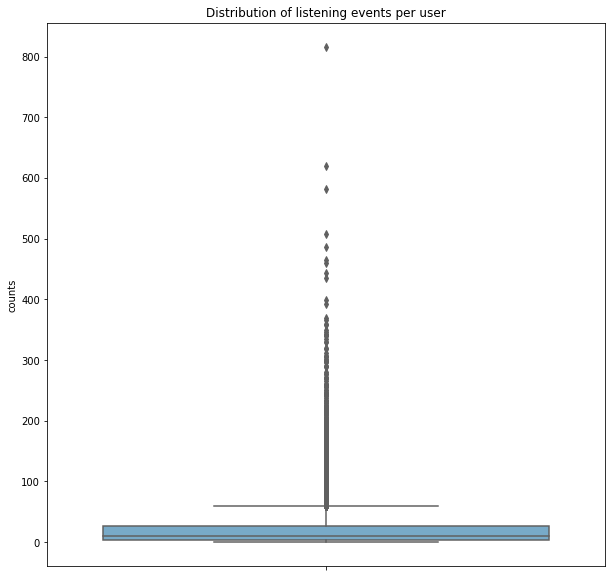

,counts
count,22291.000000
mean,20.875196
std,31.466191
min,1.000000
25%,4.000000
50%,11.000000
75%,26.000000
max,815.000000


In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.boxplot(y = data_interaction_plot_per_user['counts'], palette="Blues")
plt.title("Distribution of listening events per user")
plt.show()
data_interaction_plot_per_user[['counts']].describe()

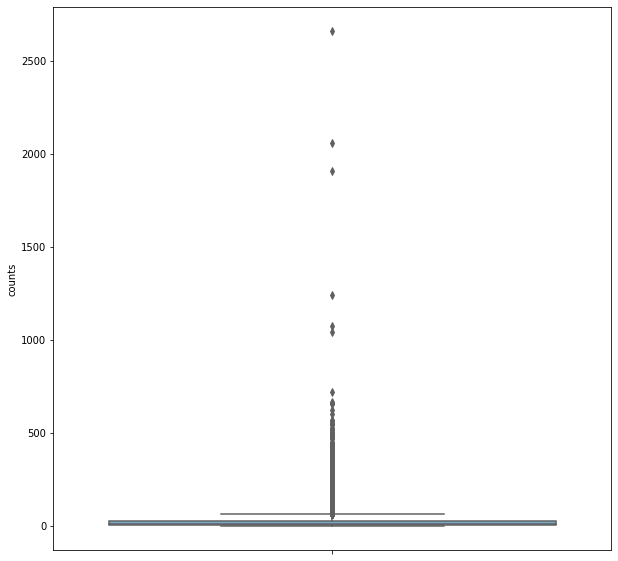

,counts
count,16973.000000
mean,27.415837
std,59.683628
min,1.000000
25%,4.000000
50%,10.000000
75%,27.000000
max,2659.000000


In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.boxplot(y = data_interaction_plot_per_track['counts'], palette="Blues")
plt.title("Distribution of listening events per track")
plt.show()
data_interaction_plot_per_track[['counts']].describe()

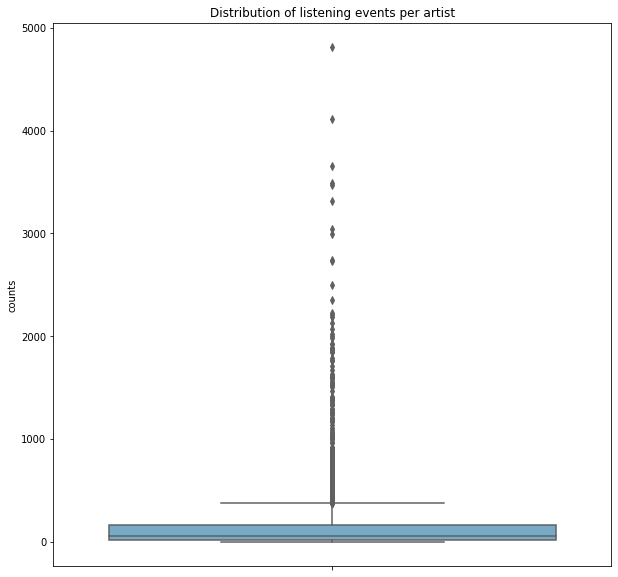

,counts
count,2715.000000
mean,171.391897
std,356.980842
min,1.000000
25%,16.000000
50%,53.000000
75%,158.500000
max,4810.000000


In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.boxplot(y = data_interaction_plot_per_artist['counts'], palette="Blues")
plt.title("Distribution of listening events per artist")
plt.show()
data_interaction_plot_per_artist[['counts']].describe()

# Data statistics

In [ ]:
# Unique numbers
print("Unique users: ", len(data_interaction.user_id.unique()))
print("Unique tracks: ", len(data_interaction.track_id.unique()))
print("Unique artists: ", len(data_tracks_tags_lyrics.track_artist.unique()))
print("Listening events: ", len(data_interaction))


Unique users:  4547
Unique tracks:  4604
Unique artists:  2736
Listening events:  225839


In [ ]:
# User gender split
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']
data_interaction.merge(data_user)[['user_id', 'gender_user']].drop_duplicates()[['gender_user']].value_counts()

gender_user
m              3614
f               669
dtype: int64

In [ ]:
data_interaction.merge(data_user)[['user_id', 'gender_user']].drop_duplicates()[['gender_user']].value_counts() / len(data_interaction.user_id.unique())

gender_user
m              0.79481
f              0.14713
dtype: float64

In [ ]:
# Artist gender split
data_interaction.merge(data_all_info)[['track_artist', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts()

gender_artist
male             705
female           181
dtype: int64

In [ ]:
data_interaction.merge(data_all_info)[['track_artist', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts() / len(data_tracks_tags_lyrics.track_artist.unique())

gender_artist
male             0.356360
female           0.099415
dtype: float64

In [ ]:
# Track gender split
data_interaction.merge(data_all_info)[['track_id', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts()

gender_artist
male             2740
female            474
dtype: int64

In [ ]:
data_interaction.merge(data_all_info)[['track_id', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts() / len(data_tracks_tags_lyrics.track_id.unique())

gender_artist
male             0.22437
female           0.04290
dtype: float64

In [ ]:
# Artist gender split in listening events
data_interaction.merge(data_all_info).drop_duplicates()[['gender_artist']].value_counts()


gender_artist
male             179932
female            31286
dtype: int64

In [ ]:
data_interaction.merge(data_all_info)[['gender_artist']].value_counts() / len(data_interaction)

gender_artist
male             0.875722
female           0.161232
dtype: float64

In [ ]:
# User gender vs artist gender in listening events
df = data_interaction.merge(data_all_info[["track_id",	"track_artist",	"gender_artist"]]).merge(data_user).drop_duplicates()
df.gender_artist.groupby([df.gender_user, df.gender_artist]).count() / len(df) * 100

gender_user  gender_artist
f            female            3.340613
             male             10.359594
m            female           11.479922
             male             74.819871
Name: gender_artist, dtype: float64

In [ ]:
df[['gender_user']].value_counts() / len(df) * 100

gender_user
m              86.299793
f              13.700207
dtype: float64

In [ ]:
df[['gender_artist']].value_counts() / len(df) * 100

NameError: ignored

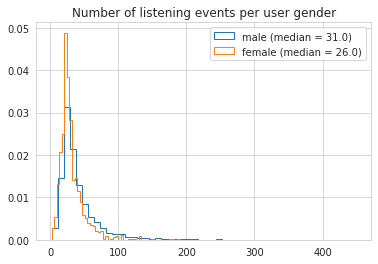

In [ ]:
# Plot: Distribution of listening events per artist gender (x-axis number of listening events, y-axis number of tracks, split up by gender)
df_female = df[df.gender_user == "f"]
df_female = df_female.groupby(['user_id']).size().reset_index(name='counts')
df_male = df[df.gender_user == "m"]
df_male = df_male.groupby(['user_id']).size().reset_index(name='counts')

plt.hist(df_male['counts'], 50, density=True, histtype='step', label=f"Male (median = {df_male['counts'].median()})")
plt.hist(df_female['counts'], 50, density=True, histtype='step', label=f"Demale (median = {df_female['counts'].median()})")
plt.ylabel("# of listening events per user")
plt.ylabel("Density")

plt.legend()
plt.title("Number of listening events per user split by user gender")
plt.show()

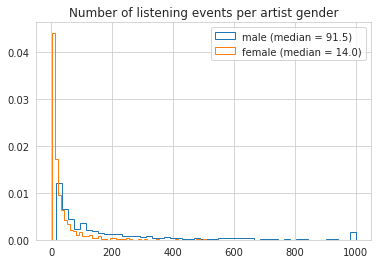

In [ ]:
df_female = df[df.gender_user == "f"]
df_female = df_female.groupby(['track_artist']).size().reset_index(name='counts')
df_female.loc[df_female['counts']>1000, 'counts'] = 1000
df_male = df[df.gender_user == "m"]
df_male = df_male.groupby(['track_artist']).size().reset_index(name='counts')
df_male.loc[df_male['counts']>1000, 'counts'] = 1000

plt.hist(df_male['counts'], 50, density=True, histtype='step', label=f"Male (median = {df_male['counts'].median()})")
plt.hist(df_female['counts'], 50, density=True, histtype='step', label=f"Female (median = {df_female['counts'].median()})")
plt.ylabel("# of listening events per artist")
plt.ylabel("Density")

plt.legend()
plt.title("Number of listening events per artist split by artist gender")
plt.show()